This ipybn script provides functions to analyse the educational data.

See function descriptions in secion "III)" for available functions.

Two different versions of the data is loaded into two data frames:
df = the true values describing the variables
df_percent_change_all_years = the percentage change from year to year on the variables




In [53]:
#Section I)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sknn.ae as ae
from scipy import linalg
from sklearn import preprocessing
from sklearn import mixture
import pylab as pl
import sklearn.metrics as metrics

In [148]:
# Section II)


# CPI adjustments
#purchesing power per dollar to convert USD to same value
df_PPD = pd.read_csv("./../data/economic_data/CPI_PurchPower.csv") 

dates = ['2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01', 
         '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', 
         '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2018-01-01']

PPD = df_PPD.loc[(df_PPD['DATE'].isin(dates))]['CUUR0000SA0R'].tolist()

base_year_2018 = PPD[len(PPD)-1]
PPD = PPD[:len(PPD)-1]

adjustments = [val/base_year_2018 for val in PPD]



#Import data and make it into percent change from previous year

#import data
df_enroll_grad       = pd.read_csv('./../data/education_data/Merged_data.csv').drop('Unnamed: 0', axis=1)
df_uni_financial     = pd.read_csv('./../data/university_financial/university_financial0116.csv').drop(['Unnamed: 0', 'TYPE'], axis=1)
df_uni_financial_aid = pd.read_csv('./../data/university_financial_aid/sfa9916_with_types.csv').drop(['Unnamed: 0', 'TYPE'], axis=1)

for col1 in df_uni_financial_aid.columns:
    if not(col1[0].isdigit() and col1[5:] in ["IGRNT_N",'LOAN_N', 'FGRNT_N', 'SGRNT_N']):
        continue
    for col2 in df_uni_financial_aid.columns:
        if not(col2[0].isdigit() and col2[:4] == col1[:4] and col1[5:9] == col2[5:9]):
            continue
        df_uni_financial_aid[col2[:-1] + "T"] = df_uni_financial_aid[col1]*df_uni_financial_aid[col2]

for col in df_uni_financial_aid.columns:
    if col[-2:] == "_N" or col[-2:] == "_A":
        df_uni_financial_aid = df_uni_financial_aid.drop(col,axis=1)




# inner merge data with key = UNITID; --> 2182 entries
df = pd.merge(df_enroll_grad, df_uni_financial, left_on='UNITID', right_on='UNITID', how='inner')
df = pd.merge(df, df_uni_financial_aid, left_on='UNITID', right_on='UNITID', how='inner')

# change naming of columns to follow same naming convention
cols = df.columns.tolist()
for i in range(len(cols)):
    if cols[i][0] == 'g':
        endYear = cols[i][-2:]
        beginingYear = str(int(endYear)-1).zfill(2)
        cols[i] = beginingYear + endYear + '_' + 'GR'
    elif cols[i][0] == 'e':
        endYear = cols[i][-2:]
        beginingYear = str(int(endYear)-1).zfill(2)
        cols[i] = beginingYear + endYear + '_' + 'EN'
df.columns = cols

# remove years that are not available for all datasets (enrollment and graduations start at 00-01)
for col in cols:
    if col[0].isdigit() and int(col[0]) > 1: #any school year (<FallYY><SpringYY>) that starts with 2 or more --> before 2000
        df = df.drop(col,axis=1)
    if col[:2] == '00':
        df = df.drop(col,axis=1)

#Drop rows missing data
df = df.dropna(how='any')        

# manipulate each column to be percentage change from last year
rows = []
for idx, row in df.iterrows():
    temp = [row['UNITID'], row['TYPE']]
    for var in ["_GR", "_EN", "_ASSETS", "_EXPENSES", "_REVENUE", "_RESEARCH", "_ANYAIDN","_LOAN_T", "_FGRNT_T", "_SGRNT_T", "_IGRNT_T",]:
        for i in range(1,15):
            prevYear = str(int(i)).zfill(2)   + str(int(i+1)).zfill(2) + var
            currYear = str(int(i+1)).zfill(2) + str(int(i+2)).zfill(2) + var
            actual_increase = 0.01
            percent_increase = 0.01
            # if previous year is 0, assume that it did not change from previous year
            if row[prevYear] != 0:
                actual_increase  = row[currYear] - row[prevYear]
                percent_increase = (actual_increase / row[prevYear])*100
                
            temp.append(percent_increase)
    rows.append(temp)

# get columns for percentage change df
cols = ["UNITID", 'TYPE']
for var in ["_GR", "_EN", "_ASSETS", "_EXPENSES", "_REVENUE", "_RESEARCH", "_ANYAIDN","_LOAN_T", "_FGRNT_T", "_SGRNT_T", "_IGRNT_T",]:
        for i in range(1,15):
            currYear = str(int(i+1)).zfill(2) + str(int(i+2)).zfill(2) + var
            cols.append(currYear)

#Generate the percentage change df  
df_percent_change_all_years = pd.DataFrame(rows, columns=cols)
df_percent_change_all_years

,UNITID,TYPE,0203_GR,0304_GR,0405_GR,0506_GR,0607_GR,0708_GR,0809_GR,0910_GR,...,0607_IGRNT_T,0708_IGRNT_T,0809_IGRNT_T,0910_IGRNT_T,1011_IGRNT_T,1112_IGRNT_T,1213_IGRNT_T,1314_IGRNT_T,1415_IGRNT_T,1516_IGRNT_T
0,105534,for-profit,263.537906,-15.590864,41.411765,22.961730,-21.853857,21.601732,29.049484,28.358621,...,88.126492,-53.568030,196.595208,3.900935,23.621483,-15.985325,44.603868,-27.494210,138.389754,82.128079
1,126605,for-profit,-20.964270,-3.594771,-21.468927,-11.942446,6.535948,-8.435583,24.288107,-84.097035,...,20.380018,38.340122,13.659674,-1.489573,-62.589849,-47.817937,127.997306,224.091581,-75.981040,150.958254
2,126702,for-profit,-12.479090,69.189602,20.718482,-28.373573,-24.327149,-42.852210,-8.277946,-20.026350,...,1.754262,-9.950086,19.472967,-50.418315,16.519759,44.082352,-46.797796,132.347132,1.044782,-29.534948
3,132338,for-profit,-71.097500,203.837342,8.595664,4.530463,-49.518432,-24.013158,-11.255411,-16.439024,...,25.141545,-12.757676,-14.707282,20.305221,8.486437,-10.612161,-15.361739,217.169970,-36.146240,-19.238515
4,138813,for-profit,3.896104,1.750000,26.781327,112.919897,-30.188107,7.170795,-21.451744,1.806918,...,19.748183,112.991552,14.289328,-1.065623,23.688826,-37.553902,7.174234,88.837438,-18.012503,-25.435183
5,147749,for-profit,4.494382,82.795699,14.705882,73.333333,-42.603550,20.618557,3.846154,-41.152263,...,155.316884,-18.263877,34.447679,112.133387,56.481481,-54.977811,48.316083,-57.405244,-61.708038,58.086124
6,153418,for-profit,-11.333333,-43.609023,64.000000,-28.997290,-18.702290,-47.887324,555.855856,-15.384615,...,-61.472603,43023.555556,-87.418065,131.061599,-84.089620,89.004011,-72.236958,803.821656,-73.558844,-83.475480
7,157021,for-profit,-51.111111,257.575758,12.500000,-15.254237,30.000000,91.794872,44.117647,2.411874,...,340.727090,-19.205643,-37.461185,-49.702568,-75.777778,-97.344742,3532.890365,-13.305898,-37.531646,29.348193
8,157270,for-profit,-1.477833,-3.833333,1.733102,12.095400,26.747720,5.515588,12.613636,-1.614531,...,6.652247,62.490660,111.185075,-62.653975,114.131823,1.098203,145.577315,-19.014644,-2.962457,71.156300
9,157766,for-profit,-17.443409,17.741935,39.178082,-1.574803,-31.000000,19.710145,-1.694915,56.403941,...,43.547544,-38.749513,93.123939,27.885714,-61.455970,42.054575,-3.559322,-58.016012,96.124031,365.169960


In [193]:
#Section III)


# Extracts from a data frame all columns matching varNames and years
# as well as UNITID and TYPE
# Input: Data frame
#        list of var names i.e: ["LOAN_A"]
#        list of school years i.e ["0809"]
#
# Output: a new df with the specified columns in the specified period
def extractRelevantData(df, varNames, years):
    cols = ["UNITID", 'TYPE']
    for var in varNames:
        for year in years:
            col = year + "_" + var
            cols.append(col)
    return df[cols]

#!!Side Effects (change original dataframe)!!
#preforms 2D-PCA on data and add "PCA_X"/"_Y" to the df
#Input: df, list of vars to exclude (i.e UNITID)
#Output: NOTHING! HAS SIDE EFFECTS
def dataWithPCA2D(df):
    cols = df.columns.difference(["UNITID", "TYPE"])
    u, s, vt = linalg.svd(preprocessing.scale(df[cols].values))
    PCA = u[:,:2] @ np.diag(s[:2])
    df['PCA_X']  = PCA[:,0] 
    df['PCA_Y']  = PCA[:,1]  
    
#Determine number of cluster in GMM
def sc_evaluate_clusters_GMM(X,max_clusters, title="GMM Silhouette Score", fig=True, fig_size=(12, 6)):
    s = np.zeros(max_clusters+1)
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(X)
        y_pred = gmm.predict(X)
        s[k] = metrics.silhouette_score(X,y_pred,metric='euclidean')
    if fig:
        plt.figure(figsize=fig_size)
        plt.plot(range(2,len(s)),s[2:])
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title(title)
        plt.show()

#!!Side Effects (change original dataframe)!!
# Finds a GMM clustering of the data
#input: df, k = number of clusters, special variables that should get
#       removed before clustering, bool = get Silhouette socre graph
#
#output: NO OUTPUT. HAS SIDE EFFECTS by adding ["CLUSTER"] to df
def clusterData(df, k, specialVarsToExlude=[], getScGraph = True):
    cols = df.columns.difference(["UNITID", "TYPE"]+specialVarsToExlude)
    scaled_data = preprocessing.scale(df[cols].values)
    if getScGraph:
        sc_evaluate_clusters_GMM(scaled_data, 12)
    gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
    gmm.fit(scaled_data)
    pred = gmm.predict(scaled_data)
    df["CLUSTER"] = pred

# Prints out a 2D-PCA scatter plot of all the points, colored by cluster
# Input: df, number of clusters, title of plot, column name of clustering
# Output: Nothing
def graphClusters(df, k, title, clusterCol="CLUSTER", clusterVals=[]):
    plt.figure(figsize=(10,10))
    c = [None]*k
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    if clusterVals == []:
        for idx, row in df.iterrows():
            c[row[clusterCol]] = pl.scatter(row['PCA_X'],row['PCA_Y'],c=colors[row[clusterCol]],s=12, alpha=0.2)
        pl.legend(c, range(k))
    else:
        clusterMaping = {}
        for i in range(len(clusterVals)):
            clusterMaping[clusterVals[i]] = i
        for idx, row in df.iterrows():
            c[clusterMaping[row[clusterCol]]] = pl.scatter(row['PCA_X'],row['PCA_Y'],c=colors[clusterMaping[row[clusterCol]]],s=12, alpha=0.2)
        pl.legend(c, clusterVals)
    pl.title(title)
    pl.show()

    
# Gives statistics about the different groups in the data set
# Input: df, type of statistical operation, column to cluster on ("CLUSTER" or "TYPE" or "")
# output: output the statistical results in new df
def dataStatistics(df_in, agregation, clusterCol=""):
    exclude =["UNITID", "PCA_X", "PCA_Y"]
    if clusterCol != "TYPE":
        exclude.append("TYPE")
    if clusterCol != "CLUSTER":
        exclude.append("CLUSTER")
    cols = df_in.columns.difference(exclude)
    df = df_in[cols]
    
    if clusterCol != "":
        if agregation == 'sum':
            return df.groupby(clusterCol).sum()
        elif agregation == 'stdiv':
            return df.groupby(clusterCol).std()
        elif agregation == 'min':
            return df.groupby(clusterCol).min()
        elif agregation == 'max':
            return df.groupby(clusterCol).max()
        elif agregation == 'mean':
            return df.groupby(clusterCol).mean()
        elif agregation == 'median':
            return df.groupby(clusterCol).median()
        elif agregation == 'corr':
            return df.groupby(clusterCol).corr()
        elif agregation == 'cov':
            return df.groupby(clusterCol).cov()
        elif agregation == 'describe':
            return df.groupby(clusterCol).describe()
    else:
        if agregation == 'sum':
            return df.sum()
        elif agregation == 'stdiv':
            return df.std()
        elif agregation == 'min':
            return df.min()
        elif agregation == 'max':
            return df.max()
        elif agregation == 'mean':
            return df.mean()
        elif agregation == 'median':
            return df.median()
        elif agregation == 'corr':
            return df.corr()
        elif agregation == 'cov':
            return df.cov()
        elif agregation == 'describe':
            return df.describe()

#labels [first group first var, second group first var, ..., first group second var, ...]
def plotAgregates(df, variables, labels, y_unit ="", x_unit="school year", title=""):
    x = []
    for col in df.columns:
        if len(x) == 0:
            x.append(col[:4])
        else:
            if int(col[:2]) > int(x[-1][:2]):
                x.append(col[:4])
            else:
                break
    dfs = []
    for i in range(len(variables)):
        dfs.append(df.iloc[:, range(len(x)*i, len(x)*(i+1))])
    
    
    ys = []
    for df_temp in dfs:
        for idx, row in df_temp.iterrows():
            temp = []
            for elm in row:
                temp.append(elm)
            ys.append(temp)
    
    
    plt.figure(figsize=(8,7))
    plt.title(title)
    plt.xlabel(x_unit)
    plt.ylabel(y_unit)
    for i in range(len(ys)):
        plt.plot(range(len(x)), ys[i], label=labels[i])
    plt.legend()
    plt.xticks(range(len(x)), x, rotation='vertical')
    plt.show()
    
    

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


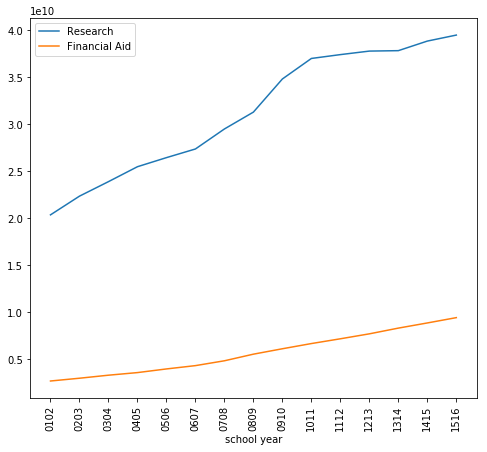

In [153]:
df_tot_spend_research_and_aid = extractRelevantData(df, ["RESEARCH", "IGRNT_T"], ["0102","0203","0304","0405","0506","0607","0708","0809","0910","1011","1112","1213","1314","1415","1516"])
cols = df_tot_spend_research_and_aid.columns.tolist()
df_tot_spend_research_and_aid['temp'] = 1
df_tot_spend_research_and_aid = dataStatistics(df_tot_spend_research_and_aid, "sum", clusterCol="temp")
df_tot_spend_research_and_aid = df_tot_spend_research_and_aid[cols[2:]]

plotAgregates(df_tot_spend_research_and_aid, ["RESEARCH","IGRNT"], ["Research", "Financial Aid"])

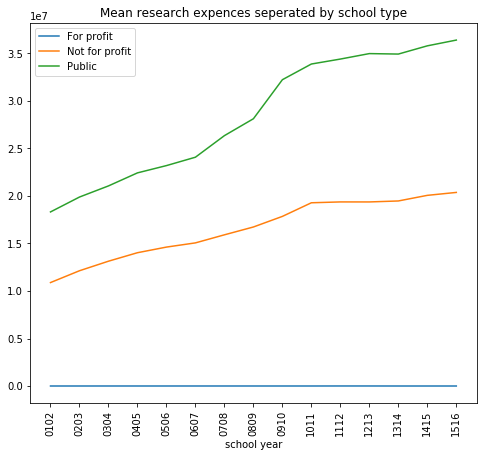

In [138]:
df_tot_spend_research = extractRelevantData(df, ["RESEARCH"], ["0102","0203","0304","0405","0506","0607","0708","0809","0910","1011","1112","1213","1314","1415","1516"])
df_tot_spend_research = dataStatistics(df_tot_spend_research, "mean", clusterCol="TYPE")
plotAgregates(df_tot_spend_research, ["RESEARCH"], ["For profit","Not for profit", "Public"], title="Mean research expences seperated by school type")


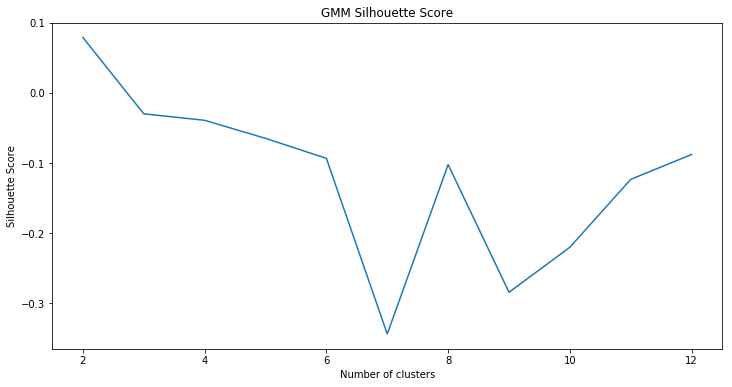

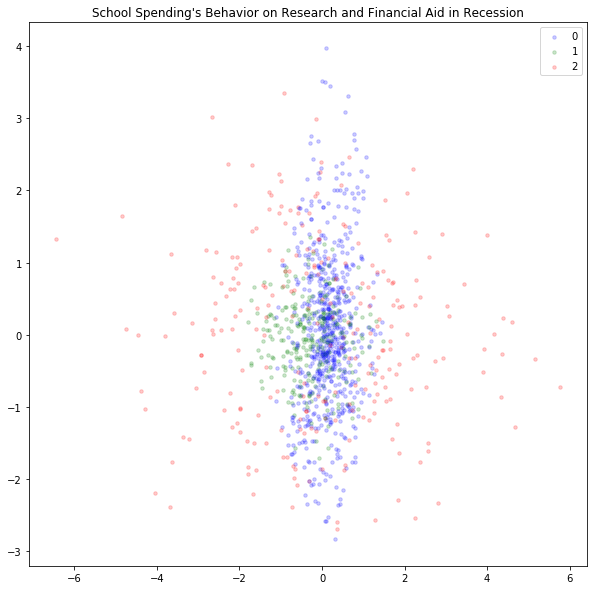

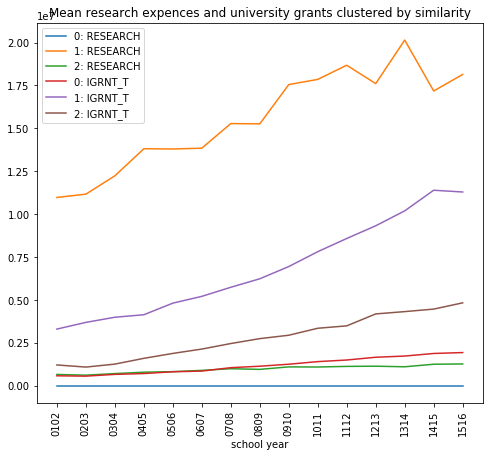

In [199]:
df_extracted = extractRelevantData(df_percent_change_all_years, ["RESEARCH", "IGRNT_T"], ["0203","0809"])

df_extracted = df_extracted.loc[((df_extracted["0203_RESEARCH"] < 90) & 
                                 (df_extracted["0203_RESEARCH"] > -90)& 
                                 (df_extracted["0809_RESEARCH"] < 90) & 
                                 (df_extracted["0809_RESEARCH"] > -90)& 
                                 (df_extracted["0203_IGRNT_T"] < 90)  & 
                                 (df_extracted["0203_IGRNT_T"] > -90) & 
                                 (df_extracted["0809_IGRNT_T"] < 90)  & 
                                 (df_extracted["0809_IGRNT_T"] > -90))]

dataWithPCA2D(df_extracted)
clusterData(df_extracted, 3, getScGraph = True)
graphClusters(df_extracted, 3, "School Spending's Behavior on Research and Financial Aid in Recession", clusterCol="CLUSTER")
results_clusters_percent_change = dataStatistics(df_extracted, "describe", clusterCol="CLUSTER")

original = extractRelevantData(df, ["RESEARCH", "IGRNT_T"], ["0102","0203","0304","0405","0506","0607","0708","0809","0910","1011","1112","1213","1314","1415","1516"])
cols = original.columns.tolist()
df_clustering_on_original = pd.merge(original , df_extracted[['UNITID', 'CLUSTER']], left_on='UNITID', right_on='UNITID', how='inner')

results_clusters_original_data = dataStatistics(df_clustering_on_original, "median", clusterCol="CLUSTER")
results_clusters_original_data = results_clusters_original_data[cols[2:]]
description_original_data = dataStatistics(df_clustering_on_original, "describe", clusterCol="CLUSTER")

plotAgregates(results_clusters_original_data, ["RESEARCH", "IGRNT_T"], ["0: RESEARCH","1: RESEARCH", "2: RESEARCH", "0: IGRNT_T","1: IGRNT_T", "2: IGRNT_T"], title="Mean research expences and university grants clustered by similarity")




In [186]:
results_clusters

0203_IGRNT_T                                                         \
               count       mean        std        min        25%        50%   
CLUSTER                                                                       
0              506.0   9.208259  30.569662 -87.812676 -10.181979   7.499170   
1              244.0  10.244160  25.060469 -85.801629  -2.709488   9.784700   
2              179.0  13.729290  24.704928 -60.343556  -0.809292  12.161055   

                              0203_RESEARCH              ...     0910_IGRNT_T  \
               75%        max         count      mean    ...              75%   
CLUSTER                                                  ...                    
0        26.215997  89.879233         506.0  0.010000    ...        21.612522   
1        25.000831  87.457561         244.0  3.625310    ...        24.792254   
2        26.249343  77.056895         179.0  7.595526    ...        17.742594   

                   0910_RESEARCH                                             \
               max         count       mean        std        min       25%   
CLUSTER                                                                       
0        88.039512         506.0   0.009980   0.000445   0.000000  0.010000   
1        88.779574         244.0   8.776526  30.229719 -80.057007 -8.856328   
2        49.385394         179.0  10.526901  12.455170 -23.649755  1.642763   

                                         
              50%        75%        max  
CLUSTER                                  
0        0.010000   0.010000   0.010000  
1        8.798571  28.587585  89.907724  
2        9.938012  18.005746  43.749110  

[3 rows x 64 columns]

In [196]:
results_clusters_original_data

,0102_RESEARCH,0203_RESEARCH,0304_RESEARCH,0405_RESEARCH,0506_RESEARCH,0607_RESEARCH,0708_RESEARCH,0809_RESEARCH,0910_RESEARCH,1011_RESEARCH,...,0607_IGRNT_T,0708_IGRNT_T,0809_IGRNT_T,0910_IGRNT_T,1011_IGRNT_T,1112_IGRNT_T,1213_IGRNT_T,1314_IGRNT_T,1415_IGRNT_T,1516_IGRNT_T
CLUSTER,,,,,,,,,,,,,,,,,,,,,
0,10978393.0,11171437,12237355,13815095,13801287,13848298,15280273,15264073,17551535,17854193,...,5219998.0,5748252.0,6243738.0,6955136.0,7821086.0,8589510.0,9329760.0,10198272.0,11399493.0,11296857.0
1,0.0,0,0,0,0,0,0,0,0,0,...,868138.0,1067776.0,1152253.0,1268680.0,1420152.0,1513503.0,1673945.0,1744010.0,1894080.0,1947231.0
2,672263.0,631850,722677,804000,835524,910436,1006129,968796,1112875,1106266,...,2150850.0,2472859.0,2758590.0,2955912.0,3362430.0,3502000.0,4197304.0,4332000.0,4478404.0,4842415.0


In [197]:
description_original_data

0102_IGRNT_T                                                  \
               count          mean           std      min        25%   
CLUSTER                                                                
0              261.0  4.414653e+06  4.277997e+06  11000.0  1277696.0   
1              649.0  1.040130e+06  1.270144e+06   1150.0    88298.0   
2              253.0  2.373697e+06  3.384240e+06   4320.0   420592.0   

                                          0102_RESEARCH                \
               50%        75%         max         count          mean   
CLUSTER                                                                 
0        3313750.0  5887023.0  25331717.0         261.0  6.224083e+07   
1         594115.0  1435896.0   7261000.0         649.0  0.000000e+00   
2        1225994.0  3371823.0  34111679.0         253.0  8.669344e+06   

             ...      1516_IGRNT_T             1516_RESEARCH                \
             ...               75%         max         count          mean   
CLUSTER      ...                                                             
0            ...        20721316.0  87457172.0         261.0  1.191232e+08   
1            ...         5161683.0  28468729.0         649.0  5.827552e+04   
2            ...        10679134.0  62646588.0         253.0  1.648286e+07   

                                                                              
                  std  min        25%         50%          75%           max  
CLUSTER                                                                       
0        2.194316e+08  0.0  2239202.0  18142071.0  143687518.0  1.431537e+09  
1        4.930500e+05  0.0        0.0         0.0          0.0  8.424684e+06  
2        6.358424e+07  0.0   319717.0   1284416.0    4583000.0  7.451693e+08  

[3 rows x 240 columns]

In [201]:
df_clustering_on_original

,UNITID,TYPE,0102_RESEARCH,0203_RESEARCH,0304_RESEARCH,0405_RESEARCH,0506_RESEARCH,0607_RESEARCH,0708_RESEARCH,0809_RESEARCH,...,0708_IGRNT_T,0809_IGRNT_T,0910_IGRNT_T,1011_IGRNT_T,1112_IGRNT_T,1213_IGRNT_T,1314_IGRNT_T,1415_IGRNT_T,1516_IGRNT_T,CLUSTER
0,126605,for-profit,0.0,0,0,0,0,0,0,0,...,81510.0,92644.0,91264.0,34142.0,17816.0,40620.0,131646.0,31620.0,79353.0,0
1,126702,for-profit,0.0,0,0,0,0,0,0,0,...,286130.0,341848.0,169494.0,197494.0,284554.0,151389.0,351748.0,355423.0,250449.0,0
2,132338,for-profit,0.0,0,0,0,0,0,0,0,...,241615.0,206080.0,247925.0,268965.0,240422.0,203489.0,645406.0,412116.0,332831.0,0
3,157021,for-profit,0.0,0,0,0,0,0,0,0,...,297564.0,186093.0,93600.0,22672.0,602.0,21870.0,18960.0,11844.0,15320.0,0
4,158723,for-profit,0.0,0,0,0,0,0,0,0,...,42000.0,29439.0,23976.0,47952.0,33300.0,28770.0,46512.0,32577.0,47950.0,0
5,173887,for-profit,0.0,0,0,0,0,0,0,0,...,224037.0,255278.0,254221.0,337617.0,455250.0,408968.0,342574.0,278681.0,203112.0,0
6,183789,for-profit,0.0,0,0,0,0,0,0,0,...,2071960.0,2552670.0,2553410.0,2432136.0,2100105.0,1899264.0,2686265.0,2801776.0,2457076.0,0
7,191959,for-profit,0.0,0,0,0,0,0,0,0,...,22810.0,12000.0,34000.0,28501.0,37996.0,20000.0,17500.0,42000.0,53508.0,0
8,192271,for-profit,0.0,0,0,0,0,0,0,0,...,365613.0,498560.0,619200.0,707642.0,876530.0,963490.0,1182206.0,1213996.0,1242972.0,0
9,193308,for-profit,0.0,0,0,0,0,0,0,0,...,448650.0,381900.0,512182.0,529635.0,3267627.0,3918872.0,2927540.0,2232153.0,3686955.0,0


In [205]:
types_of_schools_in_clusters = [[0,0,0],[0,0,0],[0,0,0]]
for idx, row in df_clustering_on_original.iterrows():
    cluster = row["CLUSTER"]
    school_t = row["TYPE"]
    if school_t == 'public':
        types_of_schools_in_clusters[cluster][0] += 1
    elif school_t == "not-for-profit":
        types_of_schools_in_clusters[cluster][1] += 1
    elif school_t == "for-profit":
        types_of_schools_in_clusters[cluster][2] += 1

print(types_of_schools_in_clusters)

[[207, 418, 24], [128, 133, 0], [145, 107, 1]]


The remaining part of this ipython, Section IV, is analysis done using the previously defined funtions
--------------------------------------------------------------------------------------------------



/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


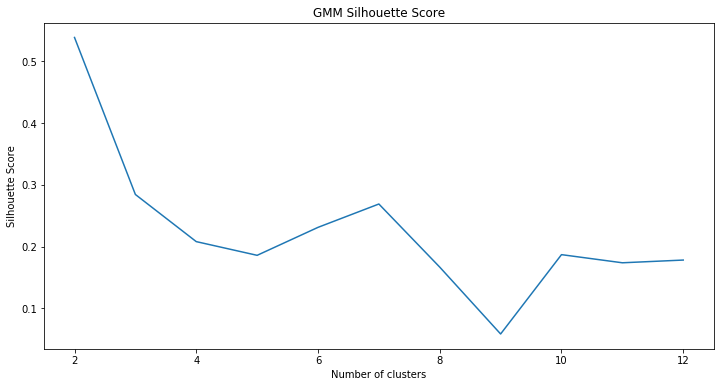

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


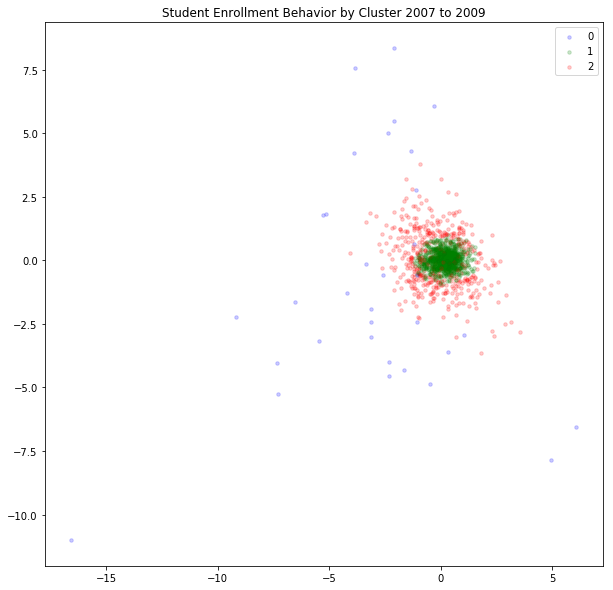

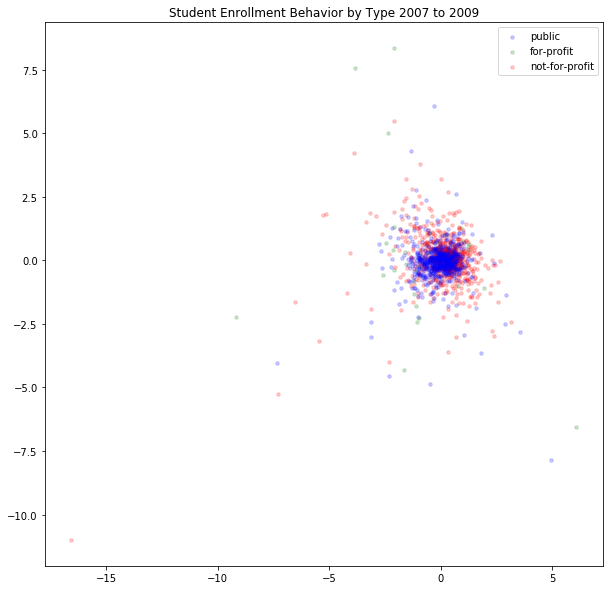

In [52]:
# Clustring of student enrollment behavior by school in 0708-0910


df_extracted = extractRelevantData(df, ["EN"], ["0708","0809","0910"])

dataWithPCA2D(df_extracted)

clusterData(df_extracted, 3, getScGraph = True)

graphClusters(df_extracted, 3, "Student Enrollment Behavior by Cluster 2007 to 2009", clusterCol="CLUSTER")
graphClusters(df_extracted, 3, "Student Enrollment Behavior by Type 2007 to 2009", clusterCol="TYPE", clusterVals=["public", "for-profit", "not-for-profit"])

results_clusters = dataStatistics(df_extracted, "describe", clusterCol="CLUSTER")
results_type = dataStatistics(df_extracted, "describe", clusterCol="TYPE")

plotAgregates(df, labels=[], y_unit ="", x_unit="school year", title="")

In [47]:
results_clusters

0708_EN                                                       \
          count      mean        std        min        25%       50%   
CLUSTER                                                                
0         450.0  2.911031  10.985030 -34.167813  -4.396674  3.018954   
1         979.0  1.207597   3.174773  -7.498661  -0.872742  1.068267   
2          33.0  7.925659  35.291193 -77.146598 -11.702128  6.779661   

                              0809_EN                ...                 \
               75%        max   count       mean     ...            75%   
CLUSTER                                              ...                  
0        10.266914  33.350489   450.0   3.577476     ...      10.135936   
1         3.304202   9.968479   979.0   1.496275     ...       3.627453   
2        37.520129  73.512632    33.0  17.939122     ...      31.517673   

                    0910_EN                                             \
                max   count       mean        std        min       25%   
CLUSTER                                                                  
0         29.344262   450.0   4.667212  10.506360 -24.200913 -2.574202   
1         11.479945   979.0   2.653808   4.391901 -10.659898 -0.079586   
2        126.739927    33.0  32.851716  63.548950 -42.976679  2.750342   

                                           
               50%        75%         max  
CLUSTER                                    
0         4.372721  11.872184   36.021784  
1         2.399423   5.450639   15.354331  
2        21.047280  44.458763  343.801090  

[3 rows x 24 columns]

In [48]:
results_type

0708_EN                                                      \
                 count      mean        std        min       25%       50%   
TYPE                                                                         
for-profit        36.0  6.506356  24.106168 -72.525021 -0.534209  5.583678   
not-for-profit   779.0  1.767093   8.192947 -30.000000 -1.874320  0.997592   
public           647.0  1.766543   7.111507 -77.146598 -0.864099  1.593939   

                                    0809_EN               ...                 \
                     75%        max   count      mean     ...            75%   
TYPE                                                      ...                  
for-profit      9.580467  73.512632    36.0  6.127217     ...      12.527307   
not-for-profit  4.502792  50.907071   779.0  1.847356     ...       4.574569   
public          4.203818  47.370787   647.0  3.102069     ...       5.546400   

                           0910_EN                                            \
                       max   count      mean        std        min       25%   
TYPE                                                                           
for-profit       93.411996    36.0  9.144769  16.048324 -22.528283  1.792972   
not-for-profit   77.981651   779.0  2.695074  15.128980 -24.200913 -1.638807   
public          126.739927   647.0  5.183548   7.550540 -42.976679  1.140327   

                                                 
                     50%        75%         max  
TYPE                                             
for-profit      9.340578  15.187095   46.385542  
not-for-profit  1.458733   5.002079  343.801090  
public          4.440822   8.258643   58.853695  

[3 rows x 24 columns]

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df_percent_change['PCA_Z']  = PCA[:,2]

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_percent_change['PCA_X'], df_percent_change['PCA_Y'], df_percent_change['PCA_Z'])

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)


In [ ]:
#prepare data for NN

#shuffle data
df_percent_change = df_percent_change.sample(frac=1).reset_index(drop=True)

#extract unitid and type in same order as data
UNITID = df_percent_change["UNITID"]
TYPE = df_percent_change["TYPE"]

# remove unitid and type from data
df_percent_change = df_percent_change.drop(['UNITID', 'TYPE'], axis=1)

# make training (1162) and test (300) set
df_train = df_percent_change[:1162]
df_test  = df_percent_change[1162:]

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

#-----------BUILD KERAS MODEL-----------

input_len = df_percent_change.shape[1]
#input_len = 784

# size of target encoding
encoding_dim = 2 

# input
input_data = Input(shape=(input_len,))
encoded = Dense(25, activation='relu')(input_data)
encoded = Dense(25, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)


decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(25, activation='relu')(decoded)
decoded = Dense(25, activation='relu')(decoded)
decoded = Dense(input_len, activation='sigmoid')(decoded)


# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_data)

# "decoded" is the lossy reconstruction of the input
#decoded = Dense(input_len, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

#-------

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

#--------

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

#--------

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(df_train, df_train,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(df_test, df_test))
